# Analysis of the model parameters estimate II
Here we check the validity of the model in terms of following parameters.

+ ELBO
+ Scatter plot for the true vs  estimated value 
+ Comparison in terms of the distribution of data 
+ Heatmaps comparing the estimated vs observed data 


In [1]:
## call python script to load data and column order
exec(open('data_file.py').read())

# load packages 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy
import vb_stan as vbfun
import sub_fun as sf
from matplotlib.backends.backend_pdf import PdfPages
figfol = 'mem_plot/'


plt.rcParams.update(plt.rcParamsDefault)

params = {'legend.fontsize': 12,
          'font.weight': 'bold',
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'axes.labelweight': 'bold',
         'xtick.labelsize':12,
          'axes.titleweight': 'bold',
         #'figure.figsize': (15,8),
          'figure.dpi': 200,
         'ytick.labelsize':12}
plt.rcParams.update(params)

%matplotlib inline

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [2]:
# Call the output from the fitted model:
fname_best = '66_model_nb_cvtest.pkl'
folname = 'MMSens/'
[holdout_mask, llpd, n_test, l,m_seed,sp_mean,\
 sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pickle.load(open(folname + fname_best, "rb"))

# -------------------------------------------------
# save model output 
fname_ot = folname + str(uid) + '_' + 'model_nb.pkl' 
#with open(fname_o, 'wb') as f:
#    pickle.dump(NB_vb, f)
with open(fname_ot, 'rb') as f:
    results = pickle.load(f)
    
sample_fname = folname + str(uid) + '_' + 'sample_model_nb_cvtest.pkl' 
with open(sample_fname, 'rb') as f:
    [Yte_sample,Yte_cv] = pickle.load(f)
    

##  ELBO

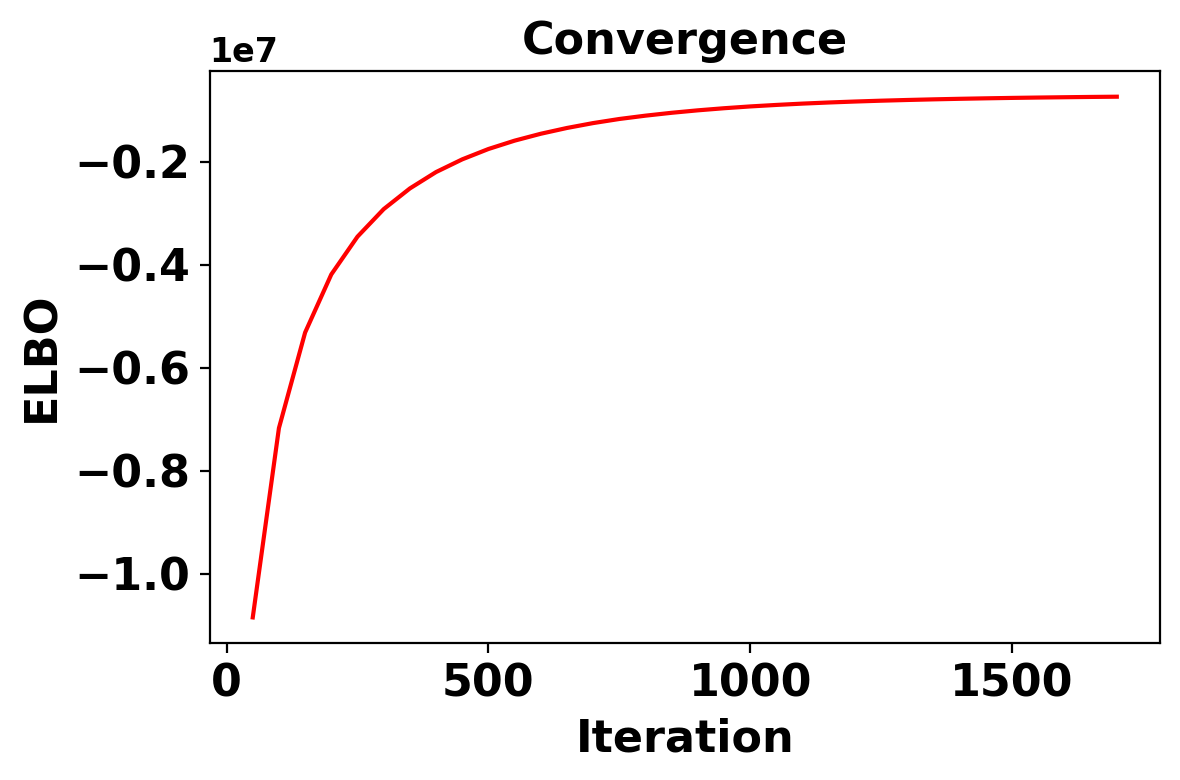

In [18]:
# ELBO
%matplotlib inline
fnamex = figfol + 'elbo_best.png'
sample_file_o = folname + str(uid) + '_' + 'nb_sample.csv'
diag_file_o = folname + str(uid) + '_' + 'nb_diag.csv'
nb_elbo = pd.read_csv(diag_file_o, comment='#', header=None)
nb_elbo.columns = ['iter', 'time', 'ELBO']  
#nb_elbo = nb_elbo[1:]
a = nb_elbo['ELBO'].to_numpy()
#a = np.sign(a)*np.log(np.abs(a))
fig, ax = plt.subplots(figsize = (6,4), dpi =200)
ax.plot(nb_elbo['iter'].to_numpy(),a , c = 'red')
ax.set_xlabel('Iteration', fontsize=16)
ax.set_ylabel('ELBO', fontsize=16)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
ax.set_title('Convergence', fontsize=16)
fig.tight_layout()
fig.savefig(fnamex)

##  Scatter plot comparing true and estimated value

In [4]:

## Get mean estimate of the MEM  
parma_mean  = dict(vbfun.vb_extract_mean(results))
muest = np.zeros((n,q))
muest1 = np.zeros((n,q))
for i in range(n):
    for j in range(q):
        muest[i,j] =  parma_mean['C0'][j] + \
            np.matmul(X[i,],parma_mean['C_geo'][j,:]) + \
            np.matmul(S[i,],np.matmul(parma_mean['A_s'],parma_mean['L_sp'][j,:])) + \
            np.matmul(B[i,],np.matmul(parma_mean['A_b'],parma_mean['L_sp'][j,:]));
            #np.matmul(Q[i,],np.matmul(parma_mean['A_m'],parma_mean['L_sp'][j,:])) + \
        if Yi[i,j] == 1:
            temp = copy.copy(Yi[i,:]);temp[j] = 0;
            muest1[i,j] = np.matmul( parma_mean['L_i'][j,:], np.matmul(parma_mean['L_sp'].T,temp))/(Bs[i]-1.0); 
            muest[i,j] = muest[i,j] + muest1[i,j];
        muest[i,j] =  T_i[i]*np.exp(muest[i,j]* parma_mean['tau'][j])



/mnt/home/amishra/jobs/microbiome/embeddings/vb_stan.py:57: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty(shape)) for name, shape in param_shapes.items()])


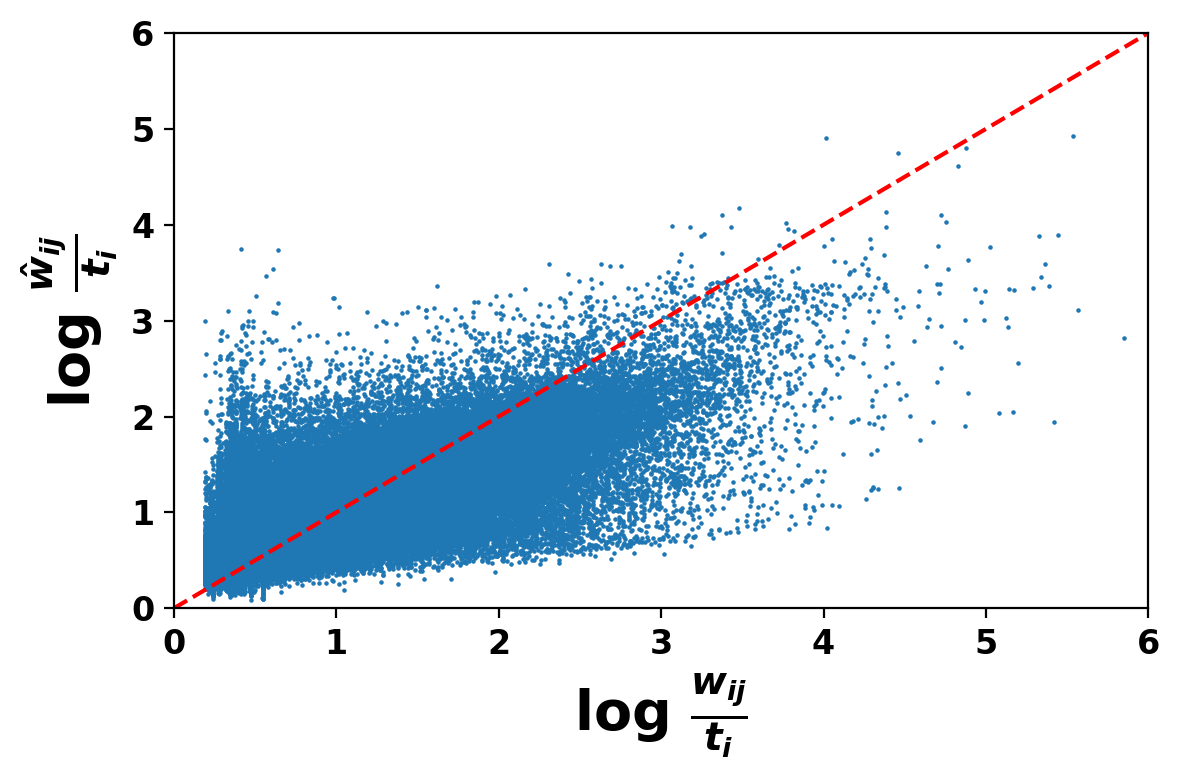

In [19]:
# Scatter plot comparing the entrywise value of the predicted and observed value of the abundance data
fnamex = figfol + 'estimation_comparison_clr.png'
a = (muest.T/T_i)
b = (Y.T/T_i)
a  = np.log(a+1)
b = np.log(b+1)
fig, ax = plt.subplots(figsize = (6,4), dpi =200)
ax.scatter(b.flatten(),a.flatten(), s = 0.4)
temp = np.linspace(0,6)
ax.plot(temp, temp,'--' , color = 'r', lw = 1.5)
ax.set_xlabel('log ' + r'$\frac{w_{ij}}{t_i}$' , fontsize=20)
ax.set_ylabel('log ' + r'$\frac{\hat{w}_{ij}}{t_i}$', fontsize=20)
ax.set_xlim([0,6])
ax.set_ylim([0,6])
fig.tight_layout()
# ax.set_title('Scatter plot')
fig.savefig(fnamex)

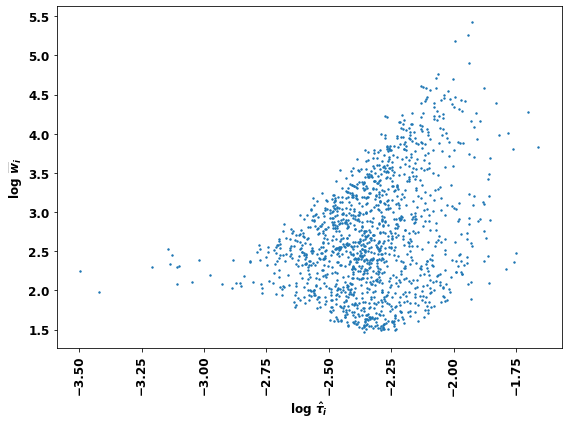

In [6]:
## compare the tau estimate  and mean abundance to understand their association
fnamex = figfol + 'role_tau.png'
b = np.log(parma_mean['tau'])
a = np.log(np.mean(Y, axis= 0))
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(b,a, s = 2)
ax.set_xlabel(r'$\log\,\,\hat{\tau}_i$')
ax.set_ylabel(r'$\log\,\,\widebar{w}_i$')
# ax.set_title('Scatter plot')
plt.xticks(rotation = 90)
fig.tight_layout()
fig.savefig(fnamex, dpi =200)

##  Comparison of the distribution of observed and predicted value of microbial abundance

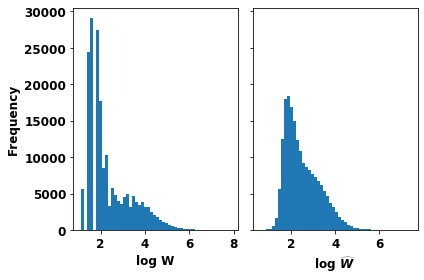

In [20]:
# Histogram to compare the distribution of the observed and predicted value of the abundance of the microbial species 
fnamex = figfol + 'modelfit_comparison_hist.png'
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = True, figsize = (6,4))
ax1.hist(np.log(np.concatenate(Y)+1), bins = 50)
ax1.set_xlabel('log W')
ax1.set_ylabel('Frequency')
ax2.hist(np.log(np.concatenate(muest)+1), bins = 50)
ax2.set_xlabel('log ' +  r'$\widehat{W}$')
fig.tight_layout()
fig.savefig(fnamex, dpi =200)

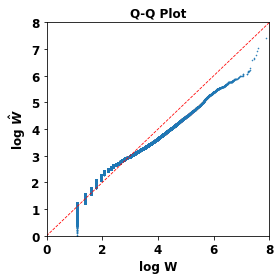

In [25]:
## Q-Q Plot to compare the distribution of the predicted and observed value of the microbial abundance
fnamex = figfol + 'best_Predicted-value.png'
a = np.sort(np.concatenate(Y+1)); 
b =  np.sort(np.concatenate(muest))
fig, ax = plt.subplots(figsize = (4,4))
ax.scatter(np.log(a), np.log(b), s = 0.3)
ax.set_xlabel('log W')
ax.set_ylabel('log ' + r'$\hat{W}$')
ax.set_ylim((0,8))
ax.set_xlim((0,8))
temp = np.linspace(0,8)
ax.plot(temp, temp,'--' , color = 'r', lw = 0.8)
ax.set_title('Q-Q Plot')
fig.tight_layout()
fig.savefig(fnamex, dpi =200)

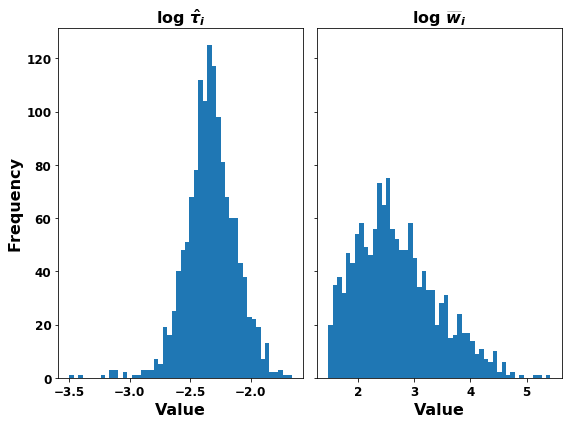

In [9]:
## compare the tau estimate  and mean abundance to understand their association
fnamex = figfol + 'best_tau_vs_spMean_hist.png'
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = True, figsize = (8,6))
ax1.hist(np.log(parma_mean['tau']), bins = 50)
ax1.set_title(r'$\log\,\,\hat{\tau}_i$', fontsize =16)
ax1.set_xlabel('Value', fontsize =16)
ax1.set_ylabel('Frequency', fontsize =16)
ax2.hist(np.log(np.mean(Y, axis= 0)), bins = 50)
ax2.set_title(r'$\log\,\,\widebar{w}_i$', fontsize =16)
ax2.set_xlabel('Value', fontsize =16)
fig.tight_layout()
fig.savefig(fnamex, dpi =200)

## Heatmaps comparing the observed and predicted value of microbial abundance

In [22]:
## Extract annotation of the microbial species 
tax_name = pd.read_csv('species_tax.csv')
tax_name = tax_name.rename(columns={'Unnamed: 0': 'OTU'})
tax_name = tax_name[1:]
tax_name.insert(0, 'Id', tax_name['OTU'].str[3:])
tax_name.columns.values[1] = 'Label'
tax_name.to_csv('node_otu.csv', index = False) 
temx = tax_name.iloc[:,:8]
temx = temx.replace(np.nan,'')
species_name = []
# Add taxonomy identifier to the each of the species name 
for i in range(temx.shape[0]):
    a = temx.iloc[i,:].values
    for j in range(a.shape[0]-1,-1,-1):
        if len(a[j]) > 0:
            species_name.append(temx.columns[j][0].lower()+'_'+ a[j])
            break;           
species_name = np.array(species_name)  
tax_name['Name'] = species_name
# tax_name['ord_abu'] = np.linspace(10,1,tax_name.shape[0])[(-1*Y.mean(axis=0)).argsort()]
tax_name['Abundance'] = Y.sum(axis=0)
tax_name[['Id']] = tax_name[['Id']].values.astype(np.int64)
tax_name = tax_name.replace(np.nan,'Empty')
tem = pd.read_csv('species_tax_anot.amended.csv').iloc[:,[1,12]]
tax_name = tax_name.merge(tem,on = 'Label')
tax_name = tax_name.rename(columns={"Ecologically_relevant_classification_aggregated": "ECR"})

## Update the new annotation in the
i = 11    # index for ECR variable 
ind_var = tax_name.iloc[:,i].values
vals, counts = np.unique(ind_var, return_counts=True)
tem_ind1 = (-1*counts).argsort()
tem_val = vals[tem_ind1][range(np.min([np.sum(counts > 10),tem_ind1.shape[0]]))]
tmp = np.setdiff1d(np.unique(ind_var), tem_val)
import sub_fun as sf
tmp = sf.return_indices_of_a(tmp, ind_var)
ind_var[tmp] = "Other" 
tax_name.iloc[:,i] = ind_var

tax_nameN = tax_name[['Label','ECR']]
tax_nameN['val'] = c_ord
tax_nameN.iloc[c_ord,2] = range(Y.shape[1])
# ## Add cluster index in the 
comunity2 = pickle.load(open('ERC_community.pkl', 'rb'))
tem = tax_nameN['Label'].map(comunity2) + 1
clust_col = np.array(['red','blue','green','yellow','grey'])[tem.values-1]
tax_nameN['Cluster'] = clust_col
tax_nameN['COMIND'] = tem
tax_nameN = tax_nameN.sort_values(["COMIND", "val"], ascending = (True, False))
v_indexN = [0]+list(np.where(np.diff(tax_nameN.COMIND.values) > 0)[0]) + [Y.shape[1]]
c_ordN = np.array(tax_nameN.index)
# tax_namex = copy.copy(tax_nameN)
# tax_namex['ERC'] = tax_namex['ECR'].map(species_col_dict)

/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

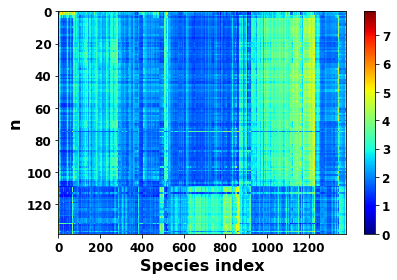

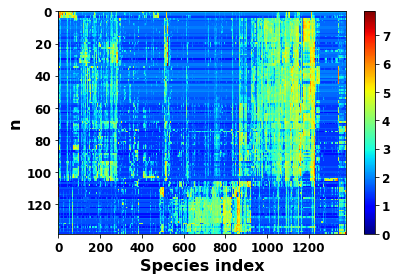

In [23]:
# Predicted value of the abundance data 
fnamex = figfol + 'W_predict.png'
import pylab as pltx
col_ulim = np.log((Y+1).max())
fig, ax = plt.subplots()
im = ax.imshow(np.log(muest[r_ord][:,c_ordN]+1),vmin=0, vmax=col_ulim,cmap='jet', aspect='auto')
ax.set_xlabel('Species index', fontsize = 16)
ax.set_ylabel('n', fontsize = 16)
fig.colorbar(im)
fig.tight_layout()
fig.savefig(fnamex, dpi =200)


# Predicted value of the abundance data 
fnamex = figfol + 'Y1379.png'
import pylab as pltx
col_ulim = np.log((Y+1).max())
fig, ax = plt.subplots()
im = ax.imshow(np.log(Y[r_ord][:,c_ordN]+1),vmin=0, vmax=col_ulim,cmap='jet', aspect='auto')
ax.set_xlabel('Species index', fontsize = 16)
ax.set_ylabel('n', fontsize = 16)
fig.colorbar(im)
fig.tight_layout()
fig.savefig(fnamex, dpi =200)


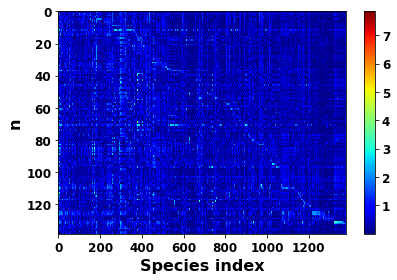

In [24]:
# compare the difference between predicted and observed value of the abbundance on the log-scale
fnamex = figfol + 'modelfit_comparison_diff.png'
col_ulim = np.log((Y+1).max())
tema = np.abs(np.log(muest+1) - np.log(Y+1))
fig, ax = plt.subplots()
im = ax.imshow(tema,cmap='jet',vmax=col_ulim, aspect='auto')
ax.set_xlabel('Species index', fontsize = 16)
ax.set_ylabel('n', fontsize = 16)
fig.colorbar(im)
# ax.set_title('|log ' + r'$\hat{W}$' +  '- log W|')
fig.tight_layout()
fig.savefig(fnamex, dpi =200)

In [15]:
## Compute mean median and mode from the posterior sample estimate
Yte_mode = np.zeros((n,q))
Yte_meadian = np.zeros((n,q))
Yte_mean = np.zeros((n,q))
for i in range(n):
    for j in range(q):
        Yte_mode[i,j] =  np.mean(sf.hpd(Yte_sample[:,i,j], alpha = 0.5))
        Yte_meadian[i,j] = np.median(Yte_sample[:,i,j])
        Yte_mean[i,j] = np.mean(Yte_sample[:,i,j])

        

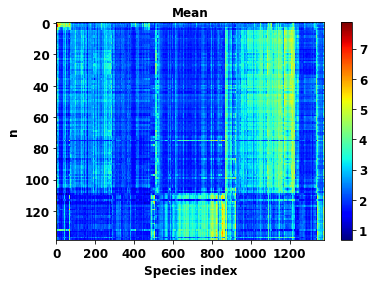

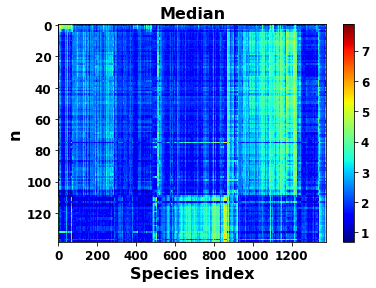

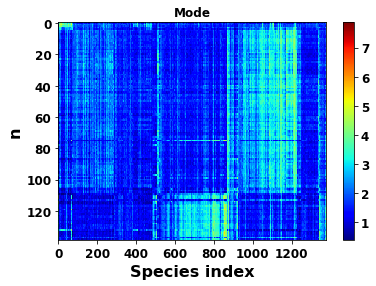

In [16]:
## Visualize mean median and mode from the posterior sample estimate

fnamex = figfol + 'mmm_post_sample.pdf'
pp = PdfPages(fnamex)

col_ulim = np.log((Y+1).max())
temp = Yte_mean[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(np.log(temp+1),cmap='jet',vmax=col_ulim, aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
fig.colorbar(im)
ax.set_title('Mean')
pp.savefig(fig, dpi =200)

temp = Yte_meadian[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(np.log(temp+1),cmap='jet',vmax=col_ulim, aspect='auto')
ax.set_xlabel('Species index', fontsize = 16)
ax.set_ylabel('n', fontsize = 16)
fig.colorbar(im)
ax.set_title('Median', fontsize = 16)
pp.savefig(fig, dpi =200)

temp = Yte_mode[r_ord][:,c_ordN]
fig, ax = pltx.subplots()
im = ax.imshow(np.log(temp+1),cmap='jet',vmax=col_ulim, aspect='auto')
ax.set_xlabel('Species index', fontsize = 16)
ax.set_ylabel('n', fontsize = 16)
fig.colorbar(im)
ax.set_title('Mode')
pp.savefig(fig, dpi =200)
pp.close()
